https://blog.csdn.net/iteapoy/article/details/106478462
# 循环神经网络
LSTM分类任务
输入多种语言的名字,判断属于哪种语言
character-level字母级别RNN


In [14]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random

## 语法
### glob
glob是python自带的一个文件操作相关模块，可以查找文件

支持通配符操作*,?,[]这三个通配符
- *代表0个或多个字符
- ?代表一个字符
- []匹配指定范围内的字符，如[0-9]匹配数字

glob.glob方法返回所有匹配的文件路径列表（list）
- 输入参数:字符串,指定路径（绝对路径或相对路径）
- 返回参数:文件名list,只包括当前目录里的文件名，不包括子文件夹

#### 使用例:

##### 绝对路径:
`glob.glob(r’c:*.txt’)`
获得C盘下的所有txt文件

`glob.glob(r’E:\pic**.jpg’)`
获得指定目录下的所有jpg文件

##### 相对路径：
- “/”：根目录，在windows系统下表示某个盘的根目录，如“E:\”；
- “./”：当前目录；（表示当前目录时，也可以去掉“./”，直接写文件名或者下级目录）
- “../”：父级目录

`glob.glob(r’../*.py’)`
获得脚本所在目录下的全部py文件


## 预处理
某些语言的字母和常见字母不一样,所以要先转换成英文字母
`string.ascii_letters`:生成字母a-z A-Z

`unicodedata`:提供对unicode数据库的访问

`unicodedata.normalize(form, unistr)`

返回Unicode字符串unistr的常规表单形式。表单的有效值为'NFC'，'NFKC'，'NFD'和'NFKD'。

对于每个字符，有两种正常形式：标准形式C和标准形式D.
- 标准形式D（NFD）也称为规范分解，并将每个字符转换为其分解形式。
- 标准形式C（NFC）首先应用规范分解，然后再组合预先组合的字符。

`unicodedata.category(unichr)`

以字符串形式返回分配给Unicode字符unichr的常规类别。
"Mn"代表`Nonspacing_Mark`

`os.path.basename(path)`
传入路径 返回文件名

In [6]:
#获取目录下的文件名,即所有语言
def findFiles(path): return glob.glob(path)
#print(findFiles('data/names/*.txt'))

#定义字母表
#包括全部字母 a-z A-Z 符号.,;
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#将unicode编码转化为plain Ascii
def unicodeToAscii(s):
    return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c)!='Mn'
      and c in all_letters
    )

#print(unicodeToAscii('Ślusàrski'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [8]:
category_lines = {}
all_categories = []

#读文件,返回转化为plain ascii码的姓名
def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

#读names目录下的所有txt文件
#文件名是label,存入all_categories
#文件内容是姓名,以键值对的形式存入字典category_lines
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
#print(all_categories)
#print(category_lines['Italian'])


### one-hot编码
分类问题,将文字转化为向量


In [9]:
import torch

#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 返回字母 letter 的索引 index
def letterToIndex(letter):
    return all_letters.find(letter)
  
# 把一个字母编码成tensor
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    # 把字母 letter 的索引设定为1，其它都是0
    tensor[0][letterToIndex(letter)] = 1
    return tensor.to(device)

# 把一个单词编码成tensor
# 传入单词,存储成(单词长度,1,字母表长度)的tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    # 遍历单词中的所有字母，对每个字母 letter 它的索引设定为1，其它都是0
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.to(device)

#print(letterToTensor('J'))
#print(lineToTensor('Jones').size())


## 模型
它是一个两层的结构
- `i2h`是输入 $x^t$ 到隐藏层 $h^t$ 的方法
- `i2o`是输入 $x^t$ 到输出$o^t$ 的方法
- `softmax`是把输出 $o^t$ 变成预测值 $y^t$ ,实际上，它在这里是一个 LogSoftmax 函数，对应的损失函数是`NLLLoss()`，而如果它是一般的 Softmax 函数，对应的损失函数就是交叉熵损失 `CrossEntropy() = Log (NLLLoss())`。

这里设定隐藏层的向量维度为128维，为了简单，可以说是隐藏层的大小是128维。

模型真正的运行步骤在 `forward()`函数中，它的输入 `input` 即为$x^t$，隐藏层`hidden` 即为 $h^t$

- `combined = torch.cat((input,hidden),1)`：把$x^t$和上一步的$h^{t-1}$拼接在一起，变成 $[ x^t , h^{t − 1} ]$
- `hidden = self.i2h(combined)`：把输入$[ x^t , h^{t − 1} ]$乘上权重 $W_h$ 变成新的隐藏层 $h^t = W_h [ x^t , h^{t − 1} ]$,输入大小是 `input_size + hidden_size`， 输出大小是 `hidden_size`
- `output = self.i2o(combined)`：把输入 $[ x^t , h^{t − 1} ]$乘上权重 $W_o$ ，得到输出$o^t = W_o [ x^t , h^{t − 1} ]$,输入大小是 `input_size + hidden_size`， 输出大小是 `output_size`
- `output = self.softmax(output)`：通过一个softmax函数，把输出 $o^t$ 变成预测值 $y^t = log \text{softmax}( o^t ) $

In [10]:
class RNN(nn.Module):
    # 初始化定义每一层的输入大小，输出大小
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    # 前向传播过程
    def forward(self, input, hidden):
        #合并x^t,h^t-1
        combined = torch.cat((input,hidden),1)
        #产生h^t
        hidden = self.i2h(combined)
        #产生o^t
        output = self.i2o(combined)
        #产生y^t
        output = self.softmax(output)
        return output, hidden

    # 初始化隐藏层状态 h0  
    def initHidden(self):
        return torch.zeros(1,self.hidden_size).to(device)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn = rnn.to(device)


In [12]:
#用字母A测试
input=letterToTensor('A')
hidden=torch.zeros(1,n_hidden).to(device)

out,next_hidden=rnn(input,hidden)
print(out)

tensor([[-2.8921, -2.9388, -2.8289, -2.8195, -2.8366, -2.9516, -2.9952, -2.8659,
         -2.8745, -2.8468, -2.8114, -2.9643, -2.9699, -2.9161, -2.8828, -2.9293,
         -2.9781, -2.7628]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [13]:
# 把18维向量 y^t 转换为分类结果
# y^t是一组概率值,选择其中最大值就是分类结果
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(out))


('Vietnamese', 17)


## 训练
随机采样一部分样本来训练

In [15]:
# 随机选择1个分类
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

# 随机选择1个样本
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# 采样10个样本试一试
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line = ', line)


category =  Greek / line =  Christou
category =  Korean / line =  Ho
category =  Italian / line =  Bove
category =  Vietnamese / line =  Tron
category =  Greek / line =  Makricosta
category =  English / line =  Corlett
category =  Russian / line =  Marhanov
category =  Korean / line =  Oh 
category =  Italian / line =  Sabbadin
category =  Chinese / line =  Shi


定义损失函数为 `NLLLoss()`， 学习率0.005。

在训练的每个循环会执行以下过程：

- 创建输入tensor和目标tensor
- 初始化隐藏层状态 $h^0$ 
- 输入每个字母$x^t$
- 保存下一个字母需要的隐藏层状态$h^t$
- 将模型预测的输出$y^t$和label $\hat{y}$ 计算损失
- 梯度反向传播
- 返回输出和损失函数


In [17]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    # RNN的循环
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i],hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 更新参数
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


### 正式训练
训练模型

In [18]:
import time
import math

n_iters = 100000   #训练100000次
print_every = 5000 #每5000次打印一次
plot_every = 1000  #每1000次画图一次

current_loss = 0   #当前损失函数
all_losses = []    #存储损失

#计算总训练时间
def timeSince(since):
    now = time.time()
    s = now-since
    return '%dm %ds'%(s//60,s%60)

start = time.time()

for iter in range(1, n_iters + 1):
    #随机采样训练样本
    category, line, category_tensor, line_tensor = randomTrainingExample()
    #训练
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '√' if guess==category else '×(%s)'%category
        print('%d %d%% (%s) %.4f %s / %s %s' % 
          (iter, iter/n_iters*100,timeSince(start),loss,line,guess,correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.4738 Navratil / Greek ×(Czech)
10000 10% (0m 22s) 3.0441 Delaney / Dutch ×(Irish)
15000 15% (0m 33s) 3.3239 Hoffman / Irish ×(German)
20000 20% (0m 44s) 2.3252 Fonda / Spanish ×(Italian)
25000 25% (0m 55s) 0.9873 Reuter / German √
30000 30% (1m 6s) 1.2841 Silveira / Portuguese √
35000 35% (1m 17s) 0.8366 Turpyatko / Russian √
40000 40% (1m 28s) 4.3822 Tangeman / Irish ×(German)
45000 45% (1m 39s) 1.9190 Severins / German ×(Dutch)
50000 50% (1m 50s) 1.4236 Ho / Korean ×(Vietnamese)
55000 55% (2m 1s) 2.9225 Macias / Portuguese ×(Spanish)
60000 60% (2m 13s) 0.0242 Pantelakos / Greek √
65000 65% (2m 24s) 0.0062 Vassilopulos / Greek √
70000 70% (2m 35s) 1.0722 Forest / French √
75000 75% (2m 47s) 7.4197 Theohari / Japanese ×(Greek)
80000 80% (2m 58s) 1.4355 Kurzmann / Dutch ×(German)
85000 85% (3m 9s) 2.4411 Croce / Scottish ×(Italian)
90000 90% (3m 20s) 0.1161 Nghiem / Vietnamese √
95000 95% (3m 32s) 0.2051 Shamoon / Arabic √
100000 100% (3m 43s) 1.6672 Alvey / French ×(

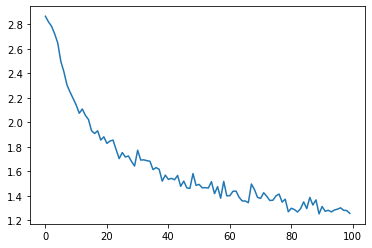

In [19]:
#绘制损失函数
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


C:\Users\USER\AppData\Local\Temp/ipykernel_15076/1091457909.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+all_categories,rotation=90)
C:\Users\USER\AppData\Local\Temp/ipykernel_15076/1091457909.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+all_categories)


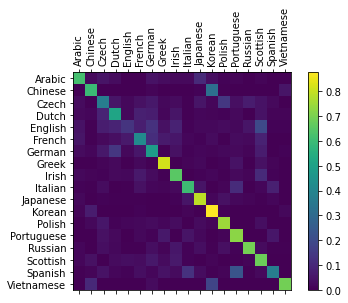

In [20]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i],hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor,line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


## 预测
对每个名字,预测3个最有可能的类别

In [21]:
def predict(input_line, n_predictions=3):
    print('\n> %s'%input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions,1,True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Coco')


> Dovesky
(-0.35) Russian
(-1.53) Czech
(-3.16) Polish

> Jackson
(-0.12) Scottish
(-2.90) Russian
(-3.33) English

> Satoshi
(-1.21) Polish
(-1.35) Japanese
(-1.62) Italian

> Coco
(-0.90) Italian
(-1.49) Spanish
(-2.22) Portuguese
